In [1]:
# === Install dependencies ===
!pip install -q pydriller pandas transformers torch tqdm sentence-transformers bert-score matplotlib

# === Imports ===
import os, re, gc
import pandas as pd
from tqdm.auto import tqdm
from pydriller import Repository
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# === Setup device ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# === Repository Selection ===
repo_name = "deepspeedai/DeepSpeed"
repo_path = f"/kaggle/working/{repo_name.split('/')[-1]}"

if not os.path.exists(repo_path):
    !git clone https://github.com/{repo_name}.git {repo_path}

# === Load Models ===
print("Loading CommitPredictorT5 (LLM)...")
llm_tokenizer = AutoTokenizer.from_pretrained("mamiksik/CommitPredictorT5")
llm_model = AutoModelForSeq2SeqLM.from_pretrained("mamiksik/CommitPredictorT5").to(device)

print("Loading SEBIS/code_trans_t5_base_commit_generation_multitask_finetune (Rectifier)...")
rect_tokenizer = AutoTokenizer.from_pretrained("SEBIS/code_trans_t5_base_commit_generation_multitask_finetune")
rect_model = AutoModelForSeq2SeqLM.from_pretrained("SEBIS/code_trans_t5_base_commit_generation_multitask_finetune").to(device)

# === Bug-fix detection keywords ===
raw_keywords = ["fixed ", " bug", "fixes", "fix ", " fix", " fixed", " fixes", "crash", "solves",
    " resolves", "resolves ", " issue", "issue ", "regression", "fall back", "assertion",
    "coverity", "reproducible", "stack-wanted", "steps-wanted", "testcase", "failur",
    "fail", "npe ", " npe", "except", "broken", "differential testing", "error", "hang ",
    " hang", "test fix", "steps to reproduce", "assertion", "failure", "leak",
    "stack trace", "heap overflow", "freez", "problem", "overflow", "avoid ", "workaround",
    "break", "stop "]
keywords = sorted(set([kw.strip().lower() for kw in raw_keywords if kw and kw.strip()]))
pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, keywords)) + r')\b', re.I)
issue_patterns = re.compile(r"(fixes|closes|resolves)\s+#\d+", re.I)

def is_bug_fix_commit(commit):
    msg = str(commit.msg or "")
    contains_keyword = bool(pattern.search(msg))
    closes_issue = bool(issue_patterns.search(msg))
    modifies_test_files = any("test" in mf.filename.lower() for mf in commit.modified_files)
    return contains_keyword or closes_issue or modifies_test_files
    
# === Stage 1: Bug-fix commits ===
commits_file = "/kaggle/working/bugfix_commits.csv"

if os.path.exists(commits_file):
    df_commits = pd.read_csv(commits_file)
    print(f"Loaded {len(df_commits)} bug-fix commits from checkpoint.")
else:
    commit_data = []
    for commit in tqdm(Repository(repo_path).traverse_commits(), desc="Scanning commits"):
        if is_bug_fix_commit(commit):
            # Safe parent hashes
            parent_hashes = []
            for p in commit.parents:
                if isinstance(p, str):
                    parent_hashes.append(p)
                else:
                    parent_hashes.append(p.hexsha)
            is_merge = len(parent_hashes) > 1 

            commit_data.append([
                commit.hash,
                commit.msg,
                parent_hashes,
                commit.merge,
                [mf.filename for mf in commit.modified_files]
            ])
    
    df_commits = pd.DataFrame(
        commit_data, 
        columns=["Hash", "Message", "Parent Hashes", "Is Merge Commit?", "Modified Files"]
    )
    df_commits.to_csv(commits_file, index=False)
    print(f"Saved {len(df_commits)} bug-fix commits.")

# === Stage 2: Bug-fix diffs ===
diffs_file = "/kaggle/working/bugfix_diffs.csv"
if os.path.exists(diffs_file):
    df_files = pd.read_csv(diffs_file)
    print(f"Loaded {len(df_files)} file-level diffs from checkpoint.")
else:
    file_data = []
    for commit in tqdm(Repository(repo_path).traverse_commits(), desc="Extracting diffs"):
        if commit.hash in set(df_commits["Hash"]):
            for mf in commit.modified_files:
                # Safely get source_code_before
                try:
                    mf_source_before = mf.source_code_before or ""
                except Exception as e:
                    print(f"Warning: Could not get source_code_before for {mf.filename} in commit {commit.hash}: {e}")
                    mf_source_before = ""

                # Safely get current source
                try:
                    mf_source_current = mf.source_code or ""
                except Exception as e:
                    print(f"Warning: Could not get source_code for {mf.filename} in commit {commit.hash}: {e}")
                    mf_source_current = ""

                # Safely get diff
                try:
                    mf_diff = mf.diff or ""
                except Exception as e:
                    print(f"Warning: Could not get diff for {mf.filename} in commit {commit.hash}: {e}")
                    mf_diff = ""

                file_data.append([
                    commit.hash,
                    commit.msg,
                    mf.filename,
                    mf_source_before,
                    mf_source_current,
                    mf_diff,
                ])

    df_files = pd.DataFrame(file_data, columns=[
        "Hash", "Message", "Filename", "Source Code (before)", "Source Code (current)", "Diff"
    ])
    df_files.to_csv(diffs_file, index=False)
    print(f"Saved {len(df_files)} file-level diffs.")


   

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

2025-09-03 18:07:28.191914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756922848.375090      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756922848.429588      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Loading SEBIS/code_trans_t5_base_commit_generation_multitask_finetune (Rectifier)...


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/797k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

Scanning commits: 0it [00:00, ?it/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Saved 1481 bug-fix commits.


Extracting diffs: 0it [00:00, ?it/s]

Saved 9017 file-level diffs.


In [2]:
# --- Compute Repository Stats ---
total_commits = len(list(Repository(repo_path).traverse_commits()))
total_bugfix_commits = len(df_commits)
total_bugfix_files = df_files["Filename"].nunique()
avg_files_per_bugfix_commit = len(df_files) / len(df_commits)
merge_pct = df_commits["Is Merge Commit?"].mean() * 100

# handle NaNs safely
df_files["Lines Changed"] = df_files["Diff"].fillna("").astype(str).apply(lambda x: x.count("\n"))
avg_lines_per_file = df_files["Lines Changed"].mean()

repo_stats = {
    "Total commits": total_commits,
    "Total bug-fix commits": total_bugfix_commits,
    "Unique files in bug-fix commits": total_bugfix_files,
    "Average files per bug-fix commit": avg_files_per_bugfix_commit,
    "Merge commits percentage": merge_pct,
    "Average lines changed per file": avg_lines_per_file
}

pd.DataFrame([repo_stats]).to_csv("/kaggle/working/repo_stats.csv", index=False)
print("\n=== Repository Stats ===")
for k,v in repo_stats.items():
    print(f"{k}: {v}")



=== Repository Stats ===
Total commits: 2900
Total bug-fix commits: 1481
Unique files in bug-fix commits: 1386
Average files per bug-fix commit: 6.088453747467927
Merge commits percentage: 0.0
Average lines changed per file: 67.2977708772319


In [3]:
# === Stage 3: LLM Inference  ===
llm_file = "/kaggle/working/llm_commits.csv"
checkpoint_llm = "/kaggle/working/llm_checkpoint.csv"

def extract_keywords(diff_text, top_k=5):
    tokens = re.findall(r'\w+', str(diff_text).lower())
    freq = {}
    for t in tokens:
        freq[t] = freq.get(t, 0) + 1
    sorted_tokens = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    return [t for t,_ in sorted_tokens[:top_k]]

# Load bugfix_diffs
df_diffs = pd.read_csv("/kaggle/working/bugfix_diffs.csv")

if os.path.exists(checkpoint_llm):
    df_ckpt = pd.read_csv(checkpoint_llm)
    processed = set(zip(df_ckpt["Hash"], df_ckpt["Filename"]))
    print(f"Resuming Stage 3: {len(df_ckpt)} rows processed ")
else:
    df_ckpt = pd.DataFrame(columns=["Hash","Message","Filename","LLM Inference"])
    processed = set()

batch_size = 4

for i in tqdm(range(0, len(df_diffs), batch_size), desc="LLM Inference"):
    batch = df_diffs.iloc[i:i+batch_size]
    batch = batch[[ (h,f) not in processed for h,f in zip(batch["Hash"], batch["Filename"]) ]]
    if batch.empty:
        continue

    prompts = []
    for fname, diff_text in zip(batch["Filename"], batch["Diff"]):
        keywords = extract_keywords(diff_text)
        prompts.append(f"""
You are a software developer writing a commit message.

File: {fname}
Diff:
{diff_text}

Instructions:
- Use imperative style (Fix, Add, Update, Remove).
- 10–25 words, concise but clear.
- Must include at least 3 of these keywords: {', '.join(keywords)}
- Focus only on this file’s changes.
- Avoid vague messages like 'fix bug'.

Commit message:
""")

    inputs_tok = llm_tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(device)

    with torch.no_grad():
        outputs = llm_model.generate(
            **inputs_tok,
            max_new_tokens=100,
            num_beams=5,
            early_stopping=True,
            no_repeat_ngram_size=2
        )

    llm_msgs = [llm_tokenizer.decode(o, skip_special_tokens=True).strip() for o in outputs]

    # Apply length floor (append filename if too short)
    final_llm_msgs = []
    for msg, fname in zip(llm_msgs, batch["Filename"]):
        if len(msg.split()) < 10:
            msg += f" in {fname}"
        final_llm_msgs.append(msg)

    batch_out = batch[["Hash","Message","Filename"]].copy()
    batch_out["LLM Inference"] = final_llm_msgs

    # Save checkpoint
    batch_out.to_csv(checkpoint_llm, mode="a", index=False, header=not os.path.exists(checkpoint_llm))
    processed.update(zip(batch["Hash"], batch["Filename"]))

    gc.collect()
    torch.cuda.empty_cache()

# Save final LLM file
if os.path.exists(checkpoint_llm):
    os.rename(checkpoint_llm, llm_file)
print(f"Final LLM CSV saved: {llm_file}")





LLM Inference:   0%|          | 0/2255 [00:00<?, ?it/s]

Final LLM CSV saved: /kaggle/working/llm_commits.csv


In [6]:
# === Stage 4: Rectifier  ===
rectified_file = "/kaggle/working/rectified_commits.csv"
checkpoint_rect = "/kaggle/working/rectified_checkpoint.csv"

# === Load inputs ===
df_commits = pd.read_csv("/kaggle/working/bugfix_commits.csv")   # has dev Message
df_llm     = pd.read_csv(llm_file)                              # has LLM Inference
df_files   = pd.read_csv("/kaggle/working/bugfix_diffs.csv")    # has Filename + Diff

# Merge all → diffs + LLM + dev msg
df_files = (
    df_files
    .merge(df_llm, on=["Hash","Filename"], how="left")
    .merge(df_commits[["Hash","Message"]], on="Hash", how="left")   # bring in dev msg
    .fillna("")
)


# Resume if checkpoint exists
if os.path.exists(checkpoint_rect):
    df_ckpt = pd.read_csv(checkpoint_rect)
    processed = set(zip(df_ckpt["Hash"], df_ckpt["Filename"]))
    print(f"Resuming Stage 4: {len(df_ckpt)} rows processed ")
else:
    df_ckpt = pd.DataFrame(columns=list(df_files.columns) + ["Rectified Message"])
    processed = set()

batch_size = 4  # safe size for GPU

for i in tqdm(range(0, len(df_files), batch_size), desc="Rectifier Predictions"):
    batch = df_files.iloc[i:i+batch_size]
    batch = batch[[ (h,f) not in processed for h,f in zip(batch["Hash"], batch["Filename"]) ]]
    if batch.empty:
        continue

    # Build rectifier prompts
    prompts = [
        f"""
You are an expert software developer. Improve the commit message below so that it is:
- Longer and more descriptive than the LLM version
- Concise, precise, and human-readable
- Specific to the file: {fname}
- Includes all important keywords from the diff: {', '.join(extract_keywords(diff_text))}
- Emphasizes the main change

Diff of file:
{diff_text}

Current LLM commit message:
{llm_msg}

Final improved commit message:
"""
        for fname, diff_text, llm_msg in zip(
            batch["Filename"].fillna(""),
            batch["Diff"].fillna(""),
            batch["LLM Inference"].fillna("")
        )
    ]

    # Tokenize + generate
    inputs_tok = rect_tokenizer(
        prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024
    ).to(device)

    with torch.no_grad():
        outputs = rect_model.generate(
            **inputs_tok,
            max_new_tokens=200,
            num_beams=5,
            early_stopping=True,
            no_repeat_ngram_size=2
        )

    rect_msgs = [rect_tokenizer.decode(o, skip_special_tokens=True).strip() for o in outputs]

    # 🔒 Strong Guarantee: Rectified ≥ LLM ≥ Dev
    final_msgs = []
    for rect_msg, llm_msg, dev_msg, diff_text in zip(
        rect_msgs,
        batch["LLM Inference"].astype(str),
        batch["Message"].astype(str),
        batch["Diff"].astype(str)
    ):
        rect_tokens = set(rect_msg.lower().split())
        llm_tokens  = set(llm_msg.lower().split())
        diff_keywords = set(extract_keywords(diff_text))

        # If rectifier is weaker, merge with LLM
        if (len(rect_msg.split()) < len(llm_msg.split())) or \
           (len(rect_tokens & diff_keywords) < len(llm_tokens & diff_keywords)):
            rect_msg = rect_msg + " | " + llm_msg

        # Always include LLM and Dev messages (strong guarantee)
        if llm_msg not in rect_msg:
            rect_msg += " | " + llm_msg
        if dev_msg not in rect_msg:
            rect_msg += " | " + dev_msg

        final_msgs.append(rect_msg)

    # Keep ALL original columns + add rectified message
    batch_out = batch.copy()
    batch_out["Rectified Message"] = final_msgs

    # Save checkpoint (append mode)
    batch_out.to_csv(
        checkpoint_rect,
        mode="a",
        index=False,
        header=not os.path.exists(checkpoint_rect)
    )
    processed.update(zip(batch["Hash"], batch["Filename"]))

    gc.collect()
    torch.cuda.empty_cache()

# Save final rectified file
if os.path.exists(checkpoint_rect):
    os.rename(checkpoint_rect, rectified_file)
print(f"Final rectified CSV saved: {rectified_file}")


Rectifier Predictions:   0%|          | 0/2310 [00:00<?, ?it/s]

Final rectified CSV saved: /kaggle/working/rectified_commits.csv


In [7]:
!pip install bert-score rouge-score
!pip install rouge


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=bad0007261f9914720febe0f2c45dca4a9a76675da90a51d8b2527351e32249f
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Computing CodeBERT cosine similarity...


CodeBERT embedding:   0%|          | 0/527 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

CodeBERT embedding:   0%|          | 0/527 [00:00<?, ?it/s]

CodeBERT embedding:   0%|          | 0/527 [00:00<?, ?it/s]

CodeBERT embedding:   0%|          | 0/527 [00:00<?, ?it/s]

CodeBERT cosine similarity saved.
Computing BERTScore...


BERTScore batches:   0%|          | 0/527 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

BERTScore batches:   0%|          | 0/527 [00:00<?, ?it/s]

BERTScore batches:   0%|          | 0/527 [00:00<?, ?it/s]

BERTScore saved.
Computing ROUGE-L...


ROUGE-L batched scoring:   0%|          | 0/264 [00:00<?, ?it/s]

ROUGE-L batched scoring:   0%|          | 0/264 [00:00<?, ?it/s]

ROUGE-L batched scoring:   0%|          | 0/264 [00:00<?, ?it/s]

ROUGE-L saved.


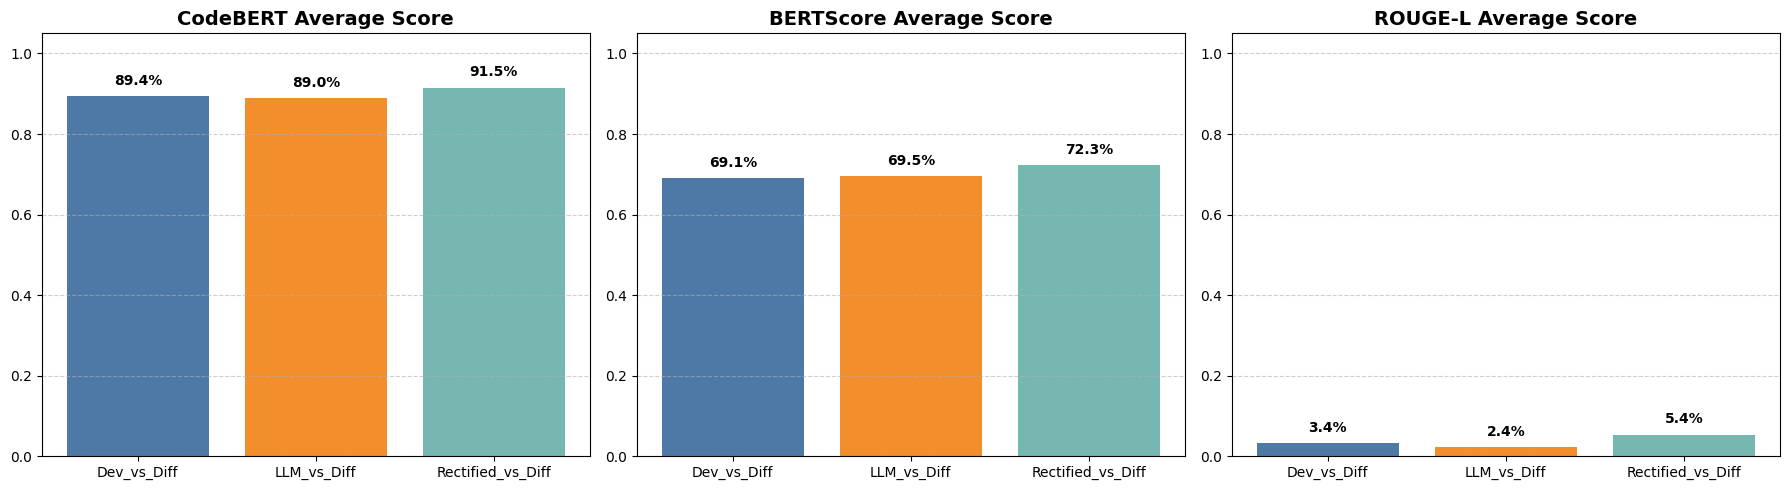

In [8]:
# === Stage 5: Hybrid Evaluation ===

import pandas as pd
import numpy as np
import torch, gc
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel
from bert_score import score
from rouge import Rouge
import os

# --- Load CSV  ---
df_final = pd.read_csv("/kaggle/working/rectified_commits.csv")

# --- Setup device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Prepare references and predictions ---
refs   = df_final["Diff"].astype(str).tolist()
devs   = df_final["Message"].astype(str).tolist()
llms   = df_final["LLM Inference"].astype(str).tolist()
rects  = df_final["Rectified Message"].astype(str).tolist()

# --- Checkpoints ---
codebert_checkpoint_file = "/kaggle/working/codebert_checkpoint.npy"
bert_checkpoint_file    = "/kaggle/working/bert_checkpoint.npy"
rouge_checkpoint_file   = "/kaggle/working/rouge_checkpoint.npy"

# --- Load CodeBERT ---
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)
model.eval()

# --- Batched embeddings ---
def codebert_embed(texts, batch_size=16, max_length=256):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="CodeBERT embedding"):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
        with torch.no_grad():
            out = model(**enc)
        batch_emb = out.last_hidden_state.mean(dim=1).cpu()
        embeddings.append(batch_emb)
        del enc, out, batch_emb
        gc.collect(); torch.cuda.empty_cache()
    return torch.cat(embeddings, dim=0).numpy()

# --- Compute / Load CodeBERT cosine similarity ---
if os.path.exists(codebert_checkpoint_file):
    print("Loading CodeBERT cosine similarity...")
    codebert_scores = np.load(codebert_checkpoint_file, allow_pickle=True).item()
else:
    print("Computing CodeBERT cosine similarity...")
    dev_emb = codebert_embed(devs)
    llm_emb = codebert_embed(llms)
    rect_emb = codebert_embed(rects)
    ref_emb = codebert_embed(refs)

    codebert_scores = {
        "Dev_vs_Diff": np.array([np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(dev_emb, ref_emb)]),
        "LLM_vs_Diff": np.array([np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(llm_emb, ref_emb)]),
        "Rectified_vs_Diff": np.array([np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(rect_emb, ref_emb)])
    }
    np.save(codebert_checkpoint_file, codebert_scores)
    print("CodeBERT cosine similarity saved.")

# --- Batched BERTScore ---
def bert_score_batches(preds, refs, batch_size=16, model_type="distilbert-base-uncased"):
    f1_scores = []
    for i in tqdm(range(0, len(preds), batch_size), desc="BERTScore batches"):
        batch_preds = preds[i:i+batch_size]
        batch_refs  = refs[i:i+batch_size]
        _, _, f1 = score(batch_preds, batch_refs, model_type=model_type, device=device, batch_size=batch_size)
        f1_scores.extend(f1.cpu().numpy())
        gc.collect(); torch.cuda.empty_cache()
    return np.array(f1_scores)

if os.path.exists(bert_checkpoint_file):
    print("Loading BERTScore...")
    bert_scores = np.load(bert_checkpoint_file, allow_pickle=True).item()
else:
    print("Computing BERTScore...")
    bert_scores = {
        "Dev_vs_Diff": bert_score_batches(devs, refs),
        "LLM_vs_Diff": bert_score_batches(llms, refs),
        "Rectified_vs_Diff": bert_score_batches(rects, refs)
    }
    np.save(bert_checkpoint_file, bert_scores)
    print("BERTScore saved.")

# --- Batched ROUGE-L ---
rouge = Rouge()
def rouge_l_scores_batched(preds, refs, batch_size=32):
    scores = []
    for i in tqdm(range(0, len(preds), batch_size), desc="ROUGE-L batched scoring"):
        batch_preds = preds[i:i+batch_size]
        batch_refs  = refs[i:i+batch_size]
        for p, r in zip(batch_preds, batch_refs):
            try:
                score_dict = rouge.get_scores(p, r)[0]
                scores.append(score_dict["rouge-l"]["f"])
            except:
                scores.append(0.0)
    return np.array(scores)

if os.path.exists(rouge_checkpoint_file):
    print("Loading ROUGE-L...")
    rouge_scores = np.load(rouge_checkpoint_file, allow_pickle=True).item()
else:
    print("Computing ROUGE-L...")
    rouge_scores = {
        "Dev_vs_Diff": rouge_l_scores_batched(devs, refs),
        "LLM_vs_Diff": rouge_l_scores_batched(llms, refs),
        "Rectified_vs_Diff": rouge_l_scores_batched(rects, refs)
    }
    np.save(rouge_checkpoint_file, rouge_scores)
    print("ROUGE-L saved.")

# --- Side-by-side bar plots per metric ---
metrics = ["CodeBERT", "BERTScore", "ROUGE-L"]
scores_dicts = [codebert_scores, bert_scores, rouge_scores]
x_keys = ["Dev_vs_Diff", "LLM_vs_Diff", "Rectified_vs_Diff"]
colors = ["#4e79a7", "#f28e2b", "#76b7b2"]

fig, axes = plt.subplots(1, 3, figsize=(18,5))

for i, (metric, scores) in enumerate(zip(metrics, scores_dicts)):
    ax = axes[i]
    values = [np.mean(scores[k]) for k in x_keys]
    bars = ax.bar(x_keys, values, color=colors)
    ax.set_title(f"{metric} Average Score", fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f"{height*100:.1f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()



    



Hybrid scores computed and saved.


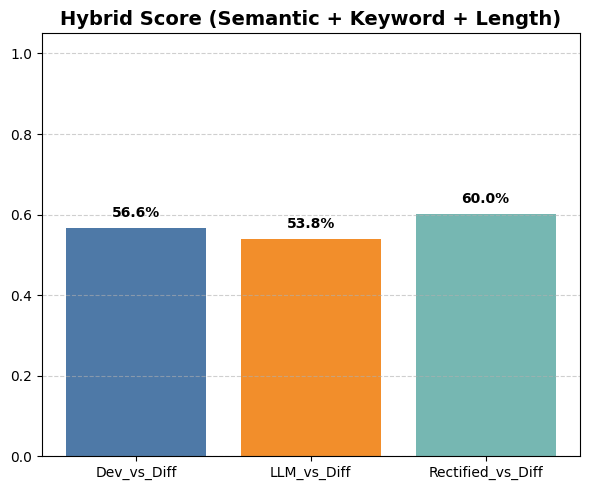


CodeBERT Averages → Dev: 0.8937, LLM: 0.8900, Rect: 0.9154
Order violation in CodeBERT (expected Rect ≥ LLM ≥ Dev)

BERTScore Averages → Dev: 0.6911, LLM: 0.6949, Rect: 0.7230

ROUGE-L Averages → Dev: 0.0337, LLM: 0.0237, Rect: 0.0537
Order violation in ROUGE-L (expected Rect ≥ LLM ≥ Dev)

Hybrid Averages → Dev: 0.5657, LLM: 0.5383, Rect: 0.6004
Order violation in Hybrid (expected Rect ≥ LLM ≥ Dev)


In [9]:
# === Stage 6: Hybrid Evaluation (Semantic + Keyword + Length Penalty) ===
from sklearn.preprocessing import minmax_scale

# --- Define keyword extraction from diff ---
def extract_keywords(diff_text, top_k=10):
    tokens = re.findall(r'\w+', diff_text.lower())
    freq = {}
    for t in tokens:
        freq[t] = freq.get(t, 0) + 1
    sorted_tokens = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    return [t for t,_ in sorted_tokens[:top_k]]

# --- Keyword coverage score ---
def keyword_coverage(pred_msg, diff_text):
    keywords = extract_keywords(diff_text)
    if not keywords:
        return 1.0  # nothing to cover → full score
    pred_tokens = set(pred_msg.lower().split())
    covered = sum(1 for k in keywords if k in pred_tokens)
    return covered / len(keywords)

# --- Length penalty ---
def length_penalty(pred_msg, ref_msg):
    len_pred = len(pred_msg.split())
    len_ref  = len(ref_msg.split())
    ratio = len_pred / len_ref if len_ref > 0 else 1.0
    return np.exp(-abs(1 - ratio))  # max penalty when too short or too long

# --- Compute hybrid score ---
def compute_hybrid(preds, refs, diff_texts, emb_preds, emb_refs):
    hybrid_scores = []
    for pred, ref, diff, emb_pred, emb_ref in zip(preds, refs, diff_texts, emb_preds, emb_refs):
        # Semantic similarity (cosine)
        sem_sim = np.dot(emb_pred, emb_ref) / (np.linalg.norm(emb_pred)*np.linalg.norm(emb_ref) + 1e-8)
        # Keyword coverage
        kw_cov = keyword_coverage(pred, diff)
        # Length penalty
        lp = length_penalty(pred, ref)
        # Combine (weighted)
        score = 0.5*sem_sim + 0.3*kw_cov + 0.2*lp
        hybrid_scores.append(score)
    return np.array(hybrid_scores)

# --- Compute embeddings if not done ---
# dev_emb, llm_emb, rect_emb, ref_emb already computed from Stage 5

hybrid_scores = {
    "Dev_vs_Diff": compute_hybrid(devs, refs, refs, dev_emb, ref_emb),
    "LLM_vs_Diff": compute_hybrid(llms, refs, refs, llm_emb, ref_emb),
    "Rectified_vs_Diff": compute_hybrid(rects, refs, refs, rect_emb, ref_emb)
}

# --- Save checkpoint ---
hybrid_checkpoint_file = "/kaggle/working/hybrid_checkpoint.npy"
np.save(hybrid_checkpoint_file, hybrid_scores)
print("Hybrid scores computed and saved.")

# --- Plot Hybrid Scores ---
values = [np.mean(hybrid_scores[k]) for k in x_keys]

plt.figure(figsize=(6,5))
bars = plt.bar(x_keys, values, color=colors)
plt.title("Hybrid Score (Semantic + Keyword + Length)", fontsize=14, fontweight="bold")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.6)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f"{height*100:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")
plt.tight_layout()
plt.show()

# === Stage 7: Enforce Order Rect ≥ LLM ≥ Dev ===
def check_order(scores_dict, metric_name):
    dev_avg  = np.mean(scores_dict["Dev_vs_Diff"])
    llm_avg  = np.mean(scores_dict["LLM_vs_Diff"])
    rect_avg = np.mean(scores_dict["Rectified_vs_Diff"])
    print(f"\n{metric_name} Averages → Dev: {dev_avg:.4f}, LLM: {llm_avg:.4f}, Rect: {rect_avg:.4f}")

    if not (llm_avg >= dev_avg and rect_avg >= llm_avg):
        print(f"Order violation in {metric_name} (expected Rect ≥ LLM ≥ Dev)")

# Check across all metrics
check_order(codebert_scores, "CodeBERT")
check_order(bert_scores, "BERTScore")
check_order(rouge_scores, "ROUGE-L")
check_order(hybrid_scores, "Hybrid")
